In [1]:
import mapsims
import numpy as np
import healpy as hp
import pysm3.units as u
from pathlib import Path
%matplotlib inline

# Access existing foreground and CMB map based simulations

The most important repository for Simons Observatory map based simulations is:

* https://github.com/simonsobs/map_based_simulations

It contains all the documentation about available released map and software, in particular:

* Check for news about available releases on the [Logbook](https://github.com/simonsobs/map_based_simulations/blob/master/LOGBOOK.md)
* Check documentation about a release and the path at NERSC, for example the last foreground/CMB [201906_highres_foregrounds_extragalactic_tophat](https://github.com/simonsobs/map_based_simulations/tree/master/201906_highres_foregrounds_extragalactic_tophat)
* Check all the configuration files used to produce a dataset

## Access channel metadata with `mapsims`

In [2]:
channels = mapsims.parse_channels("tube:ST0")

In [3]:
print(channels)

[(Channel ST0_UHF1, Channel ST0_UHF2)]


In [4]:
channel = channels[0][0]

In [5]:
channel.beam

<Quantity 19. arcmin>

Check the documentation of [`astropy.units`](https://docs.astropy.org/en/stable/units/) for details about handling units.

In [6]:
channel.center_frequency

<Quantity 225.7 GHz>

In [7]:
channel.beam.to(u.deg)

<Quantity 0.31666667 deg>

In [8]:
for ch in mapsims.parse_channels("telescope:SA"):
    print(ch)

Channel ST0_UHF1
Channel ST0_UHF2
Channel ST1_MFF1
Channel ST1_MFF2
Channel ST2_MFS1
Channel ST2_MFS2
Channel ST3_LF1
Channel ST3_LF2


In [9]:
mapsims.parse_channels("030", instrument_parameters="planck_deltabandpass")

[Channel 030]

In [10]:
for ch in mapsims.parse_channels("all") + mapsims.parse_channels("all", instrument_parameters="planck_deltabandpass"):
    print(ch.telescope, ch, ch.beam, ch.center_frequency)

LA Channel LT0_UHF1 1.0 arcmin 225.7 GHz
LA Channel LT0_UHF2 0.9 arcmin 285.4 GHz
LA Channel LT1_UHF1 1.0 arcmin 225.7 GHz
LA Channel LT1_UHF2 0.9 arcmin 285.4 GHz
LA Channel LT2_MFF1 2.2 arcmin 92.0 GHz
LA Channel LT2_MFF2 1.4 arcmin 147.5 GHz
LA Channel LT3_MFF1 2.2 arcmin 92.0 GHz
LA Channel LT3_MFF2 1.4 arcmin 147.5 GHz
LA Channel LT4_MFS1 2.2 arcmin 88.6 GHz
LA Channel LT4_MFS2 1.4 arcmin 146.5 GHz
LA Channel LT5_MFS1 2.2 arcmin 88.6 GHz
LA Channel LT5_MFS2 1.4 arcmin 146.5 GHz
LA Channel LT6_LF1 7.4 arcmin 25.7 GHz
LA Channel LT6_LF2 5.1 arcmin 38.9 GHz
SA Channel ST0_UHF1 19.0 arcmin 225.7 GHz
SA Channel ST0_UHF2 17.0 arcmin 285.4 GHz
SA Channel ST1_MFF1 42.0 arcmin 92.0 GHz
SA Channel ST1_MFF2 27.0 arcmin 147.5 GHz
SA Channel ST2_MFS1 42.0 arcmin 88.6 GHz
SA Channel ST2_MFS2 27.0 arcmin 146.5 GHz
SA Channel ST3_LF1 144.0 arcmin 25.7 GHz
SA Channel ST3_LF2 99.0 arcmin 38.9 GHz
planck Channel 030 33.102652125 arcmin 28.4 GHz
planck Channel 044 27.94348615 arcmin 44.1 GHz
planck C

## Small digression about units

PySM 3 also adds the capability of converting between $K_{CMB}$, $K_{RJ}$ and $MJ/sr$

In [11]:
(100 * u.uK_CMB).to(u.uK_RJ, equivalencies=u.cmb_equivalencies(channel.center_frequency))

<Quantity 30.83105224 uK_RJ>

In [12]:
(100 * u.uK_CMB).to(u.MJy/u.sr, equivalencies=u.cmb_equivalencies(channel.center_frequency))

<Quantity 0.04825289 MJy / sr>

# Load maps from a map based release at NERSC

In [13]:
folder = "/project/projectdirs/sobs/v4_sims/mbs/201906_highres_foregrounds_extragalactic_tophat"

In [14]:
!ls $folder/512

ame  cmb_lensed_solardipole  combined_solardip	ksz
cib  cmb_unlensed	     dust		synchrotron
cmb  combined		     freefree		tsz


In [15]:
filename_template = "{nside}/{content}/{num:04d}/simonsobs_{content}_uKCMB_{telescope}{band}_nside{nside}_{num:04d}.fits"

In [16]:
filename = Path(folder) / filename_template.format(nside=512, content="combined", num=0, 
                                                   telescope=channel.telescope.lower(), band=channel.band)

In [17]:
print(filename)

/project/projectdirs/sobs/v4_sims/mbs/201906_highres_foregrounds_extragalactic_tophat/512/combined/0000/simonsobs_combined_uKCMB_saUHF1_nside512_0000.fits


In [18]:
m = hp.read_map(filename, (0,1,2))

/global/common/software/sobs/mbs/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [19]:
m_P = np.sqrt(m[1]**2 + m[2]**2)

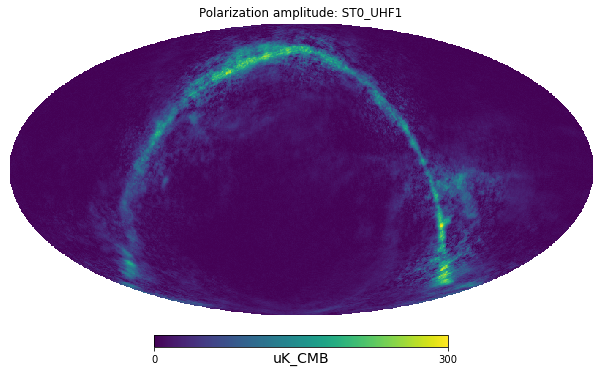

In [20]:
hp.mollview(m_P, min=0, max=300, title="Polarization amplitude: " + channel.tag, unit="uK_CMB")

# Apply standard galactic masks

Map-based releases also include standard Galactic masks that can be used for analysis,
see the documentation.

In [21]:
!ls /project/projectdirs/sobs/v4_sims/mbs/201904_highres_foregrounds_equatorial/512/masks

mask_equatorial_pol_thr1p0_fsky0p28_ns512.fits
mask_equatorial_pol_thr2p0_fsky0p50_ns512.fits
mask_equatorial_pol_thr3p0_fsky0p62_ns512.fits
mask_equatorial_pol_thr3p5_fsky0p67_ns512.fits
mask_equatorial_pol_thr4p0_fsky0p71_ns512.fits
mask_equatorial_pol_thr4p5_fsky0p75_ns512.fits


In [22]:
mask_filename = "mask_equatorial_pol_thr4p0_fsky0p71_ns512.fits"

In [23]:
mask = hp.read_map("/project/projectdirs/sobs/v4_sims/mbs/201904_highres_foregrounds_equatorial/512/masks/"+mask_filename,
                  dtype=np.bool)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [24]:
mask

array([ True,  True,  True, ..., False, False, False])

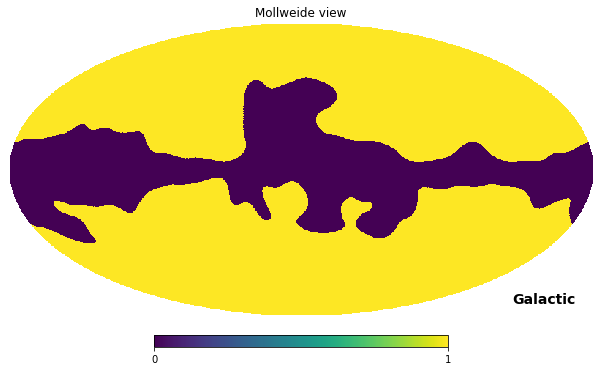

In [25]:
hp.mollview(
    mask
, coord="CG")

In [26]:
m_P_masked = m_P.copy()
m_P_masked[np.logical_not(mask)] = hp.UNSEEN

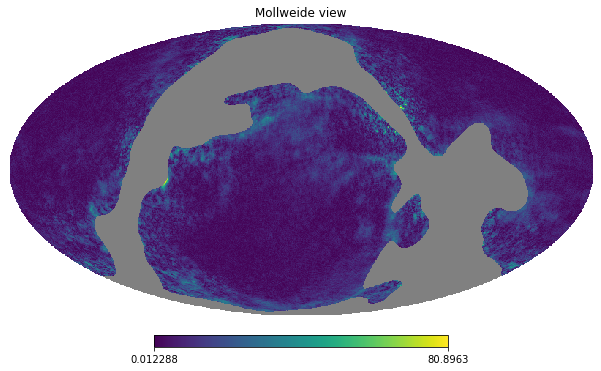

In [27]:
hp.mollview(m_P_masked)

# Apply a scanning strategy cut

The `mapsims.SONoiseSimulator` class, which is used to simulate noise, can also automatically download hitmaps that were simulated by TOAST in time domain.

In [28]:
noise = mapsims.SONoiseSimulator(nside=512)

In [29]:
hitmaps, ave_nhits = noise.get_hitmaps(tube=channel.tube)

/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF1_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")
/global/common/software/sobs/mbs/lib/python3.7/site-packages/mapsims/utils.py:71: UserWarning: Access data from /global/cfs/cdirs/sobs/www/so_mapsims_data/v0.2/healpix/ST0_UHF2_01_of_20.nominal_telescope_all_time_all_hmap.fits.gz
  warnings.warn(f"Access data from {full_path}")


For this simulation set the hitmaps are the same for both channels but in principle they might be different.

In [30]:
(hitmaps[0] - hitmaps[1]).sum()

0.0

In [31]:
m_P_survey = m_P.copy()
m_P_survey[hitmaps[0] == 0] = hp.UNSEEN

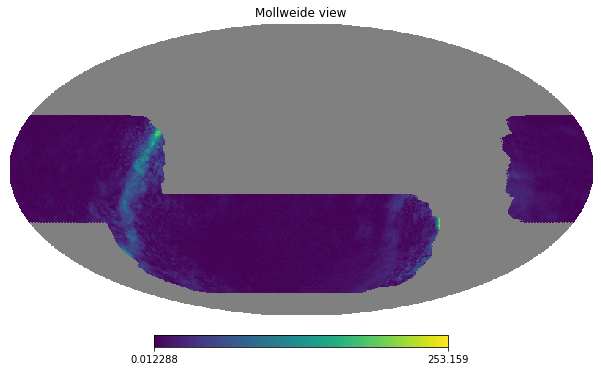

In [32]:
hp.mollview(m_P_survey)